## [2Ï£ºÏ∞®] Í∏∞Î≥∏Í≥ºÏ†ú - Ï£ºÏñ¥ÏßÑ Î¨∏Ïû•ÏóêÏÑú ÎÇòÏò¨ Îã§Ïùå Îã®Ïñ¥Î•º ÏòàÏ∏°ÌïòÎäî Î™®Îç∏ Íµ¨ÌòÑ

Ïù¥Î≤à Í≥ºÏ†úÏóêÏÑúÎäî TransformerÎ•º last word predictionÏù¥ÎùºÎäî taskÏóê Ï†ÅÏö©Ìï©ÎãàÎã§.
Last word predictionÏùÄ Token listÍ∞Ä Ï£ºÏñ¥Ï°åÏùÑ Îïå, Îã§ÏùåÏúºÎ°ú Ïò§Îäî tokenÏùÑ ÏòàÏ∏°ÌïòÎäî taskÎ°ú, Ï∂îÌõÑ Îì±Ïû•Ìï† LLMÏùò ÌïµÏã¨ÏûÖÎãàÎã§.

In [1]:
!pip install datasets sacremoses

Defaulting to user installation because normal site-packages is not writeable
,Requirement already satisfied: datasets in c:\users\rlgus\appdata\roaming\python\python311\site-packages (3.5.0)
,Requirement already satisfied: sacremoses in c:\users\rlgus\appdata\roaming\python\python311\site-packages (0.1.1)
,Requirement already satisfied: filelock in c:\users\rlgus\appdata\roaming\python\python311\site-packages (from datasets) (3.18.0)
,Requirement already satisfied: numpy>=1.17 in c:\users\rlgus\appdata\roaming\python\python311\site-packages (from datasets) (2.2.4)
,Requirement already satisfied: pyarrow>=15.0.0 in c:\users\rlgus\appdata\roaming\python\python311\site-packages (from datasets) (19.0.1)
,Requirement already satisfied: dill<0.3.9,>=0.3.0 in c:\users\rlgus\appdata\roaming\python\python311\site-packages (from datasets) (0.3.8)
,Requirement already satisfied: pandas in c:\users\rlgus\appdata\roaming\python\python311\site-packages (from datasets) (2.2.3)
,Requirement already s


,[notice] A new release of pip available: 22.3.1 -> 25.0.1
,[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Last word prediction dataset Ï§ÄÎπÑ
* collate_fn Ìï®Ïàò Ï†ïÏùò

In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence

# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìúÌïòÍ∏∞
train_ds = load_dataset("imdb", split="train[:5%]")
test_ds = load_dataset("imdb", split="test[:5%]")

# Í∂åÏû• Î∞©ÏãùÏúºÎ°ú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìúÌïòÍ∏∞
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        # Î¨∏Ïû•ÏùÑ ÌÜ†ÌÅ∞ÌôîÌïòÍ≥†, ÎßàÏßÄÎßâ ÏÑ∏ Î≤àÏß∏ Îã®Ïñ¥Î•º ÎùºÎ≤®Î°ú ÏÑ§Ï†ï
        tokenized = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids

        if len(tokenized) < 3:  # ÎÑàÎ¨¥ ÏßßÏùÄ Î¨∏Ïû•ÏùÄ Í±¥ÎÑàÎõ∞Í∏∞
            continue

        labels.append(tokenized[-3])  # ÎßàÏßÄÎßâ ÏÑ∏ Î≤àÏß∏ Îã®Ïñ¥Î•º ÎùºÎ≤®Î°ú ÏÇ¨Ïö©
        texts.append(torch.LongTensor(
            tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))  # ÎßàÏßÄÎßâ ÏÑ∏ Îã®Ïñ¥Î•º Ï†úÏô∏Ìïú ÏûÖÎ†• Î¨∏Ïû•

    # ÏûÖÎ†• Î¨∏Ïû•ÏùÑ Ìå®Îî© Ï≤òÎ¶¨ÌïòÏó¨ ÎèôÏùºÌïú Í∏∏Ïù¥Î°ú ÎßûÏ∂§
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. SelfAttention Íµ¨ÌòÑ

In [2]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        score = torch.matmul(q, k.transpose(-1, -2))  # (B, S, D) * (B, D, S) = (B, S, S)
        score = score / sqrt(self.d_model)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        result = torch.matmul(score, v)
        result = self.dense(result)

        return result

### 3. TransformerLayer Íµ¨ÌòÑ

In [3]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.sa = SelfAttention(input_dim, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

    def forward(self, x, mask):
        x = self.sa(x, mask)
        x = self.ffn(x)

        return x

### 4. positional_encoding Íµ¨ÌòÑ

In [4]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


### 5. TextClassifier Íµ¨ÌòÑ
* self.classificationÏùÑ Binary ClassificationÏóêÏÑú General ClassificationÏúºÎ°ú Î≥ÄÍ≤Ω (1 -> vocab_size)
* forward Ìï®ÏàòÏóêÏÑú classification ÌïòÍ∏∞Ï†Ñ x Í∞íÏùÑ ÎßàÏßÄÎßâ ÌÜ†ÌÅ∞Ïùò Ï∂úÎ†•Îßå ÏÇ¨Ïö©ÌïòÎØÄÎ°ú (0 -> -1)Î°ú Î≥ÄÍ≤Ω

In [5]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
        # Î™®Îç∏Ïù¥ Í∞Å Îã®Ïñ¥Ïùò ÌôïÎ•†ÏùÑ Í≥ÑÏÇ∞
        self.classification = nn.Linear(d_model, vocab_size)  # Ïù¥ÏßÑÎ∂ÑÎ•òÏóêÏÑú General ClassificationÏúºÎ°ú Î≥ÄÍ≤Ω

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, -1]  # ÎßàÏßÄÎßâ ÌÜ†ÌÅ∞Ïùò Ï∂úÎ†•Îßå ÏÇ¨Ïö©ÌïòÎØÄÎ°ú -1Î°ú Î≥ÄÍ≤Ω
        x = self.classification(x)

        return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

## 6. ÏÜêÏã§Ìï®Ïàò Î∞è Ï†ïÌôïÎèÑ(accuracy) Ìï®Ïàò Ï†ïÏùò
* ÏÜêÏã§Ìï®ÏàòÎ•º (`nn.BCEWithLogitsLoss` -> `nn.CrossEntropyLoss`)Î°ú Î≥ÄÍ≤Ω.
* Î™®Îç∏Ïùò Ï∂úÎ†•(`preds`)Î•º `torch.argmax()`Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÏòàÏ∏° Í∞íÏùÑ ÏñªÎèÑÎ°ù Î≥ÄÍ≤Ω.

Ïù¥Ïú†?
1. Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†úÏù¥Í∏∞ ÎïåÎ¨∏
    * Í∞ÄÏû• ÌôïÎ•†Ïù¥ ÎÜíÏùÄ Îã®Ïñ¥Ïùò Ïù∏Îç±Ïä§Î•º ÏòàÏ∏° Í∞íÏúºÎ°ú ÏÑ†ÌÉùÌï®.
2. Î™®Îç∏Ïùò Ï∂úÎ†•ÏùÄ logitÏù¥Í∏∞ ÎïåÎ¨∏
    * `preds`Îäî `Linear Layer`Î•º ÌÜµÍ≥ºÌïú ÌõÑ, ÏïÑÏßÅ Softmax Ìï®ÏàòÎ•º Ï†ÅÏö©ÌïòÏßÄ ÏïäÏùÄ ÏÉÅÌÉúÏûÑ.
    * Îî∞ÎùºÏÑú, Ï∂úÎ†• Í∞íÏùÄ ÌôïÎ•† Í∞íÏù¥ ÏïÑÎãàÍ≥†, Îã®ÏàúÌïú logit ÏûÑ.
    * **Í∞íÏù¥ ÌÅ¥ÏàòÎ°ù Ìï¥Îãπ ÌÅ¥ÎûòÏä§(Îã®Ïñ¥)Ïùò ÌôïÎ•†Ïù¥ Îçî ÎÜíÎã§Í≥† ÌåêÎã®Ìï®.**
3. `nn.CrossEntropyLoss()`ÏôÄ Ïó∞ÎèôÌïòÍ∏∞ ÏúÑÌï¥
    * ÌòÑÏû¨ ÏÇ¨Ïö©ÌïòÎäî ÏÜêÏã§Ìï®ÏàòÎäî `nn.CrossEntropyLoss()` ÏûÑ
    * ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú softmax Ïó∞ÏÇ∞ÏùÑ Ìè¨Ìï®Ìï®.
    * Îî∞ÎùºÏÑú `preds`Îäî `torch.argmax()`Î•º ÏÇ¨Ïö©Ìï¥ ÏòàÏ∏° Í∞íÏùÑ ÏñªÏñ¥Ïïº Ìï®.

In [6]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()  # General Classification (Îã®Ïñ¥ ÏòàÏ∏°)

optimizer = Adam(model.parameters(), lr=lr)

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)  # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†Ïùò Îã®Ïñ¥Î•º ÏòàÏ∏° Í∞íÏúºÎ°ú ÏÇ¨Ïö©

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

### 7. ÌïôÏäµ

**ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞ Ï∂îÍ∞Ä**
1. Îç∞Ïù¥ÌÑ∞ Batch Ï≤òÎ¶¨ ÎïåÎ¨∏
    * Îî•Îü¨ÎãùÏùÄ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìïú Î≤àÏóê Ï≤òÎ¶¨ÌïòÏßÄ ÏïäÍ≥†, Ïó¨Îü¨ Í∞úÏùò ÏûëÏùÄ Î∞∞ÏπòÎ°ú ÎÇòÎàÑÏñ¥ ÌïôÏäµÌï®.
    * Î∞∞Ïπò ÎßàÎã§ ÏÜêÏã§ Í∞íÏù¥ Í≥ÑÏÇ∞ÎêòÎäîÎç∞, Îã®ÏàúÌûà ÎçîÌïòÎäî Í≤ÉÏùÄ ÏùòÎØ∏Í∞Ä ÏóÜÏùå.
        * Î∞∞ÏπòÎßàÎã§ Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàòÍ∞Ä Í∞ôÏßÄ ÏïäÏùÑ ÏàòÎèÑ ÏûàÍ∏∞ ÎïåÎ¨∏ÏûÑ.
2. ÏÜêÏã§ Í∞íÏùò ÌÅ¨Í∏∞ ÎπÑÍµêÎ•º ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú
    * Î∞∞Ïπò ÌÅ¨Í∏∞ÏôÄ Í¥ÄÍ≥ÑÏóÜÏù¥ ÏùºÏ†ïÌïòÍ≤å ÎπÑÍµêÌï† Ïàò ÏûàÎèÑÎ°ù ÏÜêÏã§ Í∞íÏùÑ ÌèâÍ∑†ÏúºÎ°ú Í≥ÑÏÇ∞ÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏùå.
3. ÌïôÏäµÎ•† ÏÑ§Ï†ïÏùò Ìé∏ÏùòÏÑ±
    * ÏÜêÏã§ Í∞íÏù¥ ÎÑàÎ¨¥ Ïª§ÏßÄÎ©¥ ÌïôÏäµÎ•†Ïù¥ ÎÑàÎ¨¥ ÏûëÏïÑÏ†∏ÏÑú ÌïôÏäµÏù¥ ÎäêÎ†§ÏßÄÎäî ÌòÑÏÉÅÏù¥ Î∞úÏÉùÌï† Ïàò ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê ÌèâÍ∑† ÏÜêÏã§ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ ÌïôÏäµÎ•† ÏÑ§Ï†ïÏù¥ Ïâ¨ÏõåÏßê.


**epoch Ïàò (5 -> 10)ÏúºÎ°ú Î≥ÄÍ≤Ω**
* Train LossÎäî Ï§ÑÏñ¥Îì§Í≥† ÏûàÏßÄÎßå, Ï†ïÌôïÎèÑÎäî Í±∞Ïùò Ï¶ùÍ∞ÄÌïòÏßÄ ÏïäÍ≥† ÏûàÏùå.
* epochÏùÑ ÎäòÎ¶∞Îã§Í≥† Ìï¥ÏÑú Í∞úÏÑ†Îê† Ïó¨ÏßÄÎäî ÏóÜÏñ¥Î≥¥Ïù¥ÏßÄÎßå, Epoch ÏàòÎ•º Î≥ÄÍ≤ΩÌï¥Î≥¥ÏïòÏùå.


In [8]:
n_epochs = 10
train_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # Î™®Îç∏ÏùÑ ÌõàÎ†® Î™®ÎìúÎ°ú ÏÑ§Ï†ï
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {avg_loss:.4f}")

    with torch.no_grad():
        model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÎ™®ÎìúÎ°ú ÏÑ§Ï†ï

        # Train Accuracy Í≥ÑÏÇ∞
        train_acc = accuracy(model, train_loader)
        train_accs.append(train_acc)

        # Test Accuracy Í≥ÑÏÇ∞
        test_acc = accuracy(model, test_loader)
        test_accs.append(test_acc)

        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 10.2929
=========> Train acc: 0.004 | Test acc: 0.000
Epoch   1 | Train Loss: 9.0227
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   2 | Train Loss: 7.0005
=========> Train acc: 0.034 | Test acc: 0.034
Epoch   3 | Train Loss: 6.2115
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   4 | Train Loss: 5.9892
=========> Train acc: 0.041 | Test acc: 0.048
Epoch   5 | Train Loss: 5.9113
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   6 | Train Loss: 5.8586
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   7 | Train Loss: 5.8138
=========> Train acc: 0.040 | Test acc: 0.031
Epoch   8 | Train Loss: 5.7896
=========> Train acc: 0.042 | Test acc: 0.033
Epoch   9 | Train Loss: 5.7644
=========> Train acc: 0.040 | Test acc: 0.049


### 8. ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî

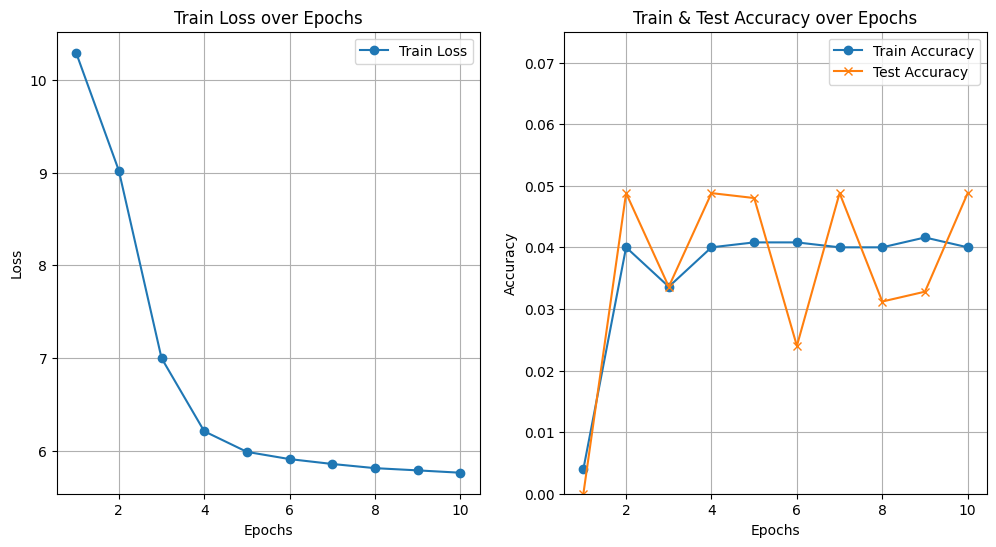

In [9]:
# ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
epochs = range(1, n_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Ï≤´ Î≤àÏß∏ Í∑∏ÎûòÌîÑ: Train Loss
ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
ax1.set_title('Train Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Îëê Î≤àÏß∏ Í∑∏ÎûòÌîÑ: Train & Test Accuracy
ax2.plot(epochs, train_accs, label='Train Accuracy', marker='o')
ax2.plot(epochs, test_accs, label='Test Accuracy', marker='x')
ax2.set_title('Train & Test Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

ax2.set_ylim(0.0, 0.075)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.show()

### 9. Í∑∏ÎûòÌîÑ Í≤∞Í≥º Î∂ÑÏÑù
1. Train Loss Í∑∏ÎûòÌîÑ
    * Train LossÍ∞Ä Íæ∏Ï§ÄÌûà Í∞êÏÜåÌïòÎäî Î™®Ïäµ
    * ÌïôÏäµÏù¥ ÏßÑÌñâÎêòÎ©¥ÏÑú ÏÜêÏã§ Í∞íÏù¥ Ï†êÏ†ê Ï§ÑÏñ¥ÎìúÎäî Í±¥ Î™®Îç∏Ïù¥ ÌïôÏäµÏùÑ ÏûòÌïòÍ≥† ÏûàÏùåÏùÑ ÏùòÎØ∏
    * ÌïòÏßÄÎßå **Í∞êÏÜå ÏÜçÎèÑÍ∞Ä Îπ†Î•¥ÏßÄ ÏïäÍ∏∞ ÎïåÎ¨∏Ïóê ÌïôÏäµÏù¥ ÎäêÎ¶¨Í≤å ÏßÑÌñâÎêòÍ≥† ÏûàÏùÑ Í∞ÄÎä•ÏÑ±**Ïù¥ ÏûàÏùå
2. Train & Test Accuracy Í∑∏ÎûòÌîÑ
    * Train AccuracyÎäî **0.04 (4%) Ï†ïÎèÑÏóêÏÑú Ï°∞Í∏àÏî© Ï¶ùÍ∞ÄÌïòÍ≥† ÏûàÏùå**.
    * Test AccuracyÎäî **ÏúÑÏïÑÎûòÎ°ú ÎßéÏù¥ Î≥ÄÎèôÎêòÍ≥† ÏûàÏùå**.
        * ÌäπÌûà, Ï†ïÌôïÎèÑÍ∞Ä 0.05 (5%) ÏóêÏÑú 0.02 (2%) Ï†ïÎèÑÎ°ú ÌÅ¨Í≤å Îñ®Ïñ¥ÏßÄÍ∏∞ÎèÑ Ìï®.
        * ÌïôÏäµÏù¥ Ïûò ÎêòÏßÄ ÏïäÍ±∞ÎÇò, Î™®Îç∏Ïù¥ Overfitting ÎòêÎäî Underfitting ÎêòÍ≥† ÏûàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.


### Î¨∏Ï†ú Î∂ÑÏÑù
1. **Train LossÎäî Í∞êÏÜåÌïòÍ≥† ÏûàÏßÄÎßå, Ï†ïÌôïÎèÑÎäî Ï¶ùÍ∞ÄÌïòÏßÄ ÏïäÏùå.**
    * ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò overfitting Í∞ÄÎä•ÏÑ±.
    * Î™®Îç∏Ïù¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ìå®ÌÑ¥ÏùÑ Ï†úÎåÄÎ°ú Ïû°ÏßÄ Î™ªÌïòÍ≥† ÏûàÏùÑ Ïàò ÏûàÏùå.
2. **Test AccuracyÏùò Î≥ÄÎèôÏù¥ Îß§Ïö∞ ÌÅº**
    * Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ ÎÑàÎ¨¥ ÏûëÍ±∞ÎÇò, Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Ïùò Ìå®ÌÑ¥ÏùÑ Ï†úÎåÄÎ°ú ÌïôÏäµÌïòÏßÄ Î™ªÌï®.
    * ÌïôÏäµÎ•†Ïù¥ ÎÑàÎ¨¥ ÌÅ¨Í±∞ÎÇò ÏûëÏùÑ Îïå Î∞úÏÉùÌï† Ïàò ÏûàÏùå.


### Í∞úÏÑ† Î∞©Ïïà
üí°ÌïôÏäµÎ•†ÏùÑ Ï†àÎ∞òÏúºÎ°ú Ï°∞Ï†ïÌïòÏó¨ (lr = 0.0005)Î°ú Îã§Ïãú ÌïôÏäµÌï¥Î≥¥Í∏∞<br/>
üí°Transformer Layer Ïàò (`n_layers`)Î•º ÎäòÎ¶¨Í±∞ÎÇò, `d_model` ÌÅ¨Í∏∞Î•º ÌÇ§ÏõåÎ≥¥Í∏∞<br/>
`model = TextClassifier(vocab_size=len(tokenizer), d_model=64, n_layers=4, dff=128)`<br/>
üí°IMDB Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎäòÎ†§Î≥¥Í∏∞ (ÌòÑÏû¨ 5% -> 10%, 20%, 50%)<br/>
üí°MNIST Ïã¨ÌôîÌïôÏäµÏóê ÏÇ¨Ïö©Ìï¥Î≥∏ Dropout LayerÎ•º Ï∂îÍ∞ÄÌïòÏó¨ Overfitting Î∞©ÏßÄ Ìï¥Î≥¥Í∏∞<br/>

